<a href="https://colab.research.google.com/github/sayakpaul/A-Barebones-Image-Retrieval-System/blob/master/Similarity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Todo: Normalize the extracted features. 

In [1]:
!pip install -q tf-nightly

     |████████████████████████████████| 325.0MB 49kB/s 
     |████████████████████████████████| 460kB 58.8MB/s 
     |████████████████████████████████| 6.7MB 43.0MB/s 


In [2]:
from google.colab import auth as google_auth
google_auth.authenticate_user()

In [3]:
!gsutil ls -lh gs://image-retrieval-system/

 61.18 MiB  2020-07-30T02:08:44Z  gs://image-retrieval-system/facenet_like_model.h5
 61.18 MiB  2020-07-30T02:15:46Z  gs://image-retrieval-system/facenet_like_model_less_data.h5
 19.83 MiB  2020-07-30T02:19:26Z  gs://image-retrieval-system/facenet_like_model_less_data_mbnetv2.h5
 19.83 MiB  2020-07-30T02:36:45Z  gs://image-retrieval-system/facenet_like_model_less_data_mbnetv2_da.h5
171.57 MiB  2020-07-29T14:45:20Z  gs://image-retrieval-system/full_length_flower_classifier.h5
TOTAL: 5 objects, 349788400 bytes (333.58 MiB)


In [14]:
!gsutil -m cp -r gs://image-retrieval-system/*.h5 .

Copying gs://image-retrieval-system/facenet_like_model.h5...
Copying gs://image-retrieval-system/facenet_like_model_less_data_mbnetv2.h5...
Copying gs://image-retrieval-system/facenet_like_model_less_data.h5...
Copying gs://image-retrieval-system/full_length_flower_classifier.h5...
Copying gs://image-retrieval-system/facenet_like_model_less_data_mbnetv2_da.h5...
- [5/5 files][333.6 MiB/333.6 MiB] 100% Done                                    
Operation completed over 5 objects/333.6 MiB.                                    


In [1]:
import tensorflow as tf
print(tf.__version__)

2.4.0-dev20200729


In [2]:
from sklearn.neighbors import NearestNeighbors
from tensorflow.keras.applications import *
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
import matplotlib.pyplot as plt
import numpy as np
import time

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

In [3]:
# Fix the random seeds
np.random.seed(666)
tf.random.set_seed(666)

In [4]:
# Gather Flowers dataset
train_ds, validation_ds = tfds.load(
    "tf_flowers",
    split=["train[:85%]", "train[85%:]"],
    as_supervised=True
)

In [5]:
# Image resize
size = (224, 224)

train_ds = train_ds.map(lambda x, y: (tf.image.resize(x, size), y))
validation_ds = validation_ds.map(lambda x, y: (tf.image.resize(x, size), y))

In [6]:
# Other preprocessing utils
def scale_img(img, label):
    img = tf.cast(img, tf.float32) / 255.
    return (img, label)

# Construct the batched dataset
batch_size = 64
AUTO = tf.data.experimental.AUTOTUNE

train_ds = train_ds.map(scale_img, num_parallel_calls=AUTO).\
    shuffle(1024).\
    batch(batch_size).\
    prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
validation_ds = validation_ds.map(scale_img, num_parallel_calls=AUTO).\
    batch(batch_size).\
    prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [7]:
supervised_model = load_model("full_length_flower_classifier.h5")
supervised_model.summary()

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [8]:
feature_extractor = Model(supervised_model.input, supervised_model.layers[-4].output)
feature_extractor.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [18]:
# Finding out nearest neighbors for query features
validation_features = feature_extractor.predict(validation_ds)
neighbors = NearestNeighbors(n_neighbors=5,
    algorithm='brute',
    metric='euclidean').fit(validation_features)

In [19]:
images, labels = next(iter(validation_ds.take(1)))
print(images.shape, labels.shape)

(64, 224, 224, 3) (64,)


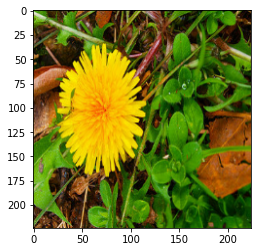

In [20]:
random_index = int(np.random.choice(images.shape[0], 1))
plt.imshow(images[random_index])
plt.show()

In [22]:
distances, indices = neighbors.kneighbors([validation_features[random_index]])
for i in range(5):
    print(distances[0][i])

0.0
7.76598
7.823412
8.653496
8.899257


In [16]:
plt.imshow(train_images[indices[0][1]], interpolation='lanczos')

InvalidArgumentError: ignored